# Evaluate our fine-tuned BERT model

In [1]:
import numpy as np
import pandas as pd

In [2]:
# Load keywords and labels

data = {
    "train": pd.concat(
        [
            pd.read_csv("../data/wine_cleaned_train.csv"),
            pd.read_csv("../data/wine_cleaned_val.csv"),
        ]
    ),
    "test": pd.read_csv("../data/wine_cleaned_test.csv"),
}

In [3]:
# Load onnx model and tokenizer

import onnxruntime as rt
import torch
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
sess = rt.InferenceSession(
    "../models/bert-mini-finetune.onnx",
    providers=["CUDAExecutionProvider", "CPUExecutionProvider"],
)

2022-10-07 16:35:59.935782600 [W:onnxruntime:Default, onnxruntime_pybind_state.cc:566 CreateExecutionProviderInstance] Failed to create CUDAExecutionProvider. Please reference https://onnxruntime.ai/docs/reference/execution-providers/CUDA-ExecutionProvider.html#requirements to ensure all dependencies are met.


In [4]:
# Read label2idx json

import json

with open("../models/label_to_idx.json", "r") as f:
    label2idx = json.load(f)

data["train"]["label"] = data["train"]["region_variety"].map(lambda x: label2idx[x])
data["test"]["label"] = data["test"]["region_variety"].map(lambda x: label2idx[x])

In [5]:
# Get predictions in batches
from tqdm import tqdm
from sklearn.metrics import top_k_accuracy_score


def get_predictions(texts, y_true, batch_size=1024):
    all_preds = []
    all_logits = []

    t = tqdm(range(0, len(texts), batch_size))

    for batch_start in t:
        batch_end = batch_start + batch_size
        batch = texts[batch_start:batch_end].tolist()
        batch_labels = y_true[batch_start:batch_end]
        inputs = tokenizer(batch, padding=True, return_tensors="pt")
        outputs = sess.run(
            None,
            {
                "input_ids": inputs["input_ids"].numpy(),
                "attention_mask": inputs["attention_mask"].numpy(),
                "token_type_ids": inputs["token_type_ids"].numpy(),
            },
        )
        logits = outputs[0]
        # Predict probabilities, if label in top 5, return label, else the first in top 5
        y_pred = np.array([logits[i].argsort()[-5:][::-1] for i in range(len(logits))])
        y_pred = np.array(
            [
                batch_labels[i] if batch_labels[i] in y_pred[i] else y_pred[i][0]
                for i in range(len(y_pred))
            ]
        )
        all_preds.extend(y_pred)
        all_logits.extend(logits.tolist())

    return all_preds, all_logits

In [6]:
train_preds, train_logits = get_predictions(
    data["train"]["description"].values, data["train"]["label"].values
)
print(
    "Train top5 accuracy:",
    top_k_accuracy_score(data["train"]["label"], train_logits, k=5),
)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 109/109 [14:27<00:00,  7.96s/it]


Train top5 accuracy: 0.920407833563697


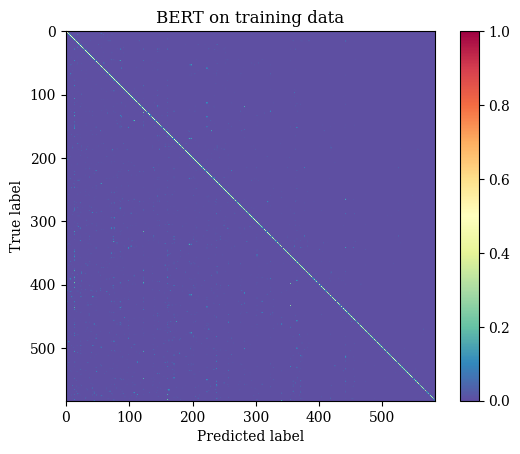

In [7]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix

from matplotlib import rcParams

rcParams["font.family"] = "serif"

import matplotlib.pyplot as plt


def plot_conf_matrix(y_true, y_pred, title, filename):
    """Plot confusion matrix."""
    conf_mat = confusion_matrix(y_true, y_pred)
    conf_mat = conf_mat.astype("float") / conf_mat.sum(axis=1)[:, np.newaxis]
    plt.imshow(conf_mat, cmap="Spectral_r")
    plt.colorbar()
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.title(title)
    plt.savefig(filename, bbox_inches="tight")


plot_conf_matrix(
    data["train"]["label"],
    train_preds,
    "BERT on training data",
    "../img/confusion_matrix_bert_train.png",
)

In [8]:
test_preds, test_logits = get_predictions(
    data["test"]["description"].values, data["test"]["label"].values
)
print(
    "Test top5 accuracy:", top_k_accuracy_score(data["test"]["label"], test_logits, k=5)
)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:42<00:00,  7.04s/it]


Test top5 accuracy: 0.8341005967604433


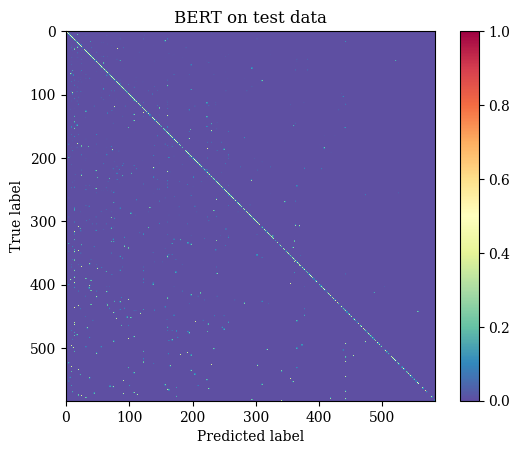

In [9]:
plot_conf_matrix(
    data["test"]["label"],
    test_preds,
    "BERT on test data",
    "../img/confusion_matrix_bert_test.png",
)